# **Convolutional Autoencoder**

Convolutional Autoencoders (CAE) are a class of **unsupervised neural networks** designed to learn efficient, low-dimensional data representations. By forcing the input through a structural bottleneck, the network is compelled to discard noise and redundancy, retaining only the most robust **spatial features and latent structures** required to reconstruct the original data.

### **Concept**
The CAE operates on the principle of **representation learning** through compression. Unlike standard autoencoders that flatten images into dense vectors immediately, CAEs preserve the spatial locality of image data by utilizing convolutional layers. The architecture consists of two distinct functional blocks:

1. **The Encoder (Contraction Path):** This network progressively reduces the spatial dimensions of the input while increasing the depth of feature maps. Through a series of convolution and pooling operations, it extracts a hierarchy of features from simple edges to complex shapes culminating in a highly compressed **Latent Vector**.
2. **The Decoder (Expansion Path):** This network takes the compressed latent vector and attempts to reconstruct the original input. It utilizes upsampling or transposed convolutions to recover spatial resolution, translating the abstract latent features back into pixel intensities.

### **The Latent Manifold**
The core value of a CAE lies in the **Latent Space** (or Bottleneck). Because the bottleneck restricts the flow of information, the network cannot simply copy the input to the output. Instead, it must learn a **latent manifold**, a lower-dimensional geometric structure where semantically similar data points (for example, all variations of the digit '3') cluster together.

By mapping high-dimensional image space to this compressed manifold, the model learns the underlying "rules" or data distribution of the training set.

### **Interpretation & Utility**
- **Feature Extraction:** The encoder acts as a powerful, self-supervised feature extractor. The learned filters capture essential visual patterns without requiring human-labeled data.
- **Dimensionality Reduction:** Similar to PCA but non-linear, CAEs reduce complex data into manageable vectors for visualization (like, t-SNE or UMAP) or storage.
- **Anomaly Detection:** Because the model learns to reconstruct *normal* data (digits), it will fail to accurately reconstruct *anomalous* data (a letter or a corrupted image). A high reconstruction error acts as a signal for outliers.

# **Imports**

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# **Tranformations & Data Loader**

In [2]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

# **Convolutional Autoencoder Architecture**

This block defines a **convolutional autoencoder** using PyTorch, designed for image reconstruction tasks such as denoising or dimensionality reduction on grayscale images.

- **Encoder**: Compresses the input image into a lower-dimensional latent representation using convolutional layers, ReLU activations, batch normalization, and max pooling for spatial downsampling.
- **Decoder**: Reconstructs the original image from the latent representation using upsampling layers, convolutional layers, batch normalization, and ReLU activations, with a final sigmoid activation to produce pixel values in the range $[0, 1]$.

The `forward` method returns both the reconstructed image and the latent representation, enabling reconstruction loss computation as well as access to the encoded features.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# **Device, Loss & Optimizer Setup**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device-> {device}')
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device-> cuda


# **Training**

In [5]:
num_epochs = 5

for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(data_loader):
        images = images.to(device)
        
        outputs, _ = model(images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0023
Epoch [2/5], Loss: 0.0023
Epoch [3/5], Loss: 0.0014
Epoch [4/5], Loss: 0.0014
Epoch [5/5], Loss: 0.0012


# **Visualization of Encoder Feature Maps**

This block extracts and visualizes the **latent feature maps** produced by the encoder part of the trained autoencoder for a single MNIST image.

Key steps include:
- Selecting one sample from the MNIST dataset and adding a batch dimension
- Switching the model to evaluation mode and disabling gradient computation
- Passing the image through the encoder to obtain the latent representation
- Visualizing the 32 resulting feature maps in a grid layout

This visualization helps in understanding what spatial features the encoder learns for a given digit by showing how different convolutional filters respond to the input image.

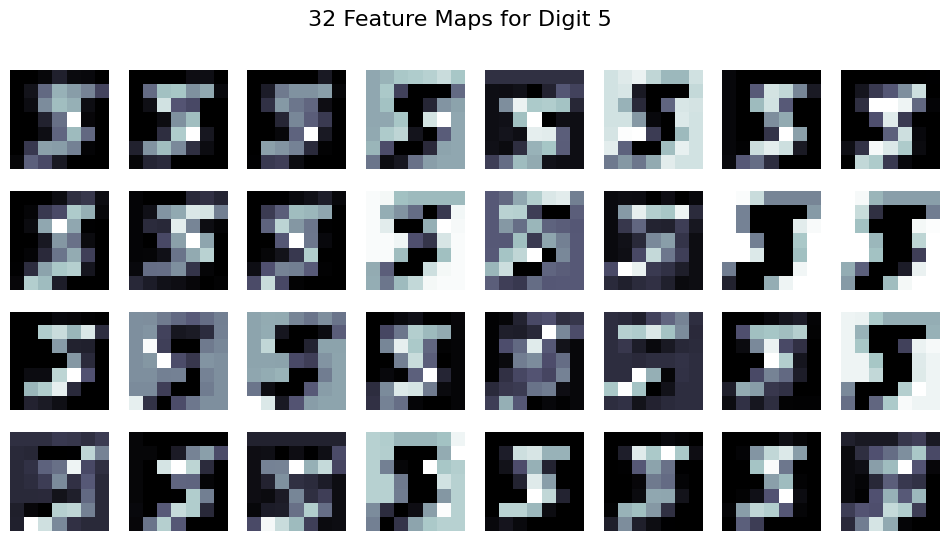

In [6]:
image, label = mnist_data[0] 
image = image.unsqueeze(0).to(device) 

model.eval()
with torch.no_grad():
    latent_representation = model.encoder(image)

features = latent_representation.squeeze(0).cpu()

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle(f'32 Feature Maps for Digit {label}', fontsize=16)

for i in range(32):
    row = i // 8
    col = i % 8
    ax = axes[row, col]
    ax.imshow(features[i], cmap='bone') 
    ax.axis('off')

plt.show()

# **Latent Space Visualization**

This block collects latent representations from the trained autoencoder and visualizes them using **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to explore the structure of the learned latent space.

The process includes:
- Extracting latent vectors and corresponding labels from the dataset without computing gradients
- Flattening the latent feature maps into vector representations
- Sampling a fixed number of latent vectors for efficient visualization
- Reducing the high-dimensional latent space to two dimensions using t-SNE
- Plotting the 2D embeddings with color-coded digit labels

This visualization provides insight into how well the autoencoder clusters similar digits in its latent space and reveals the separability of learned representations.
For faster performance, $10000$ images are selected out of $60000$ available for training.

Computing t-SNE for 10000 samples...


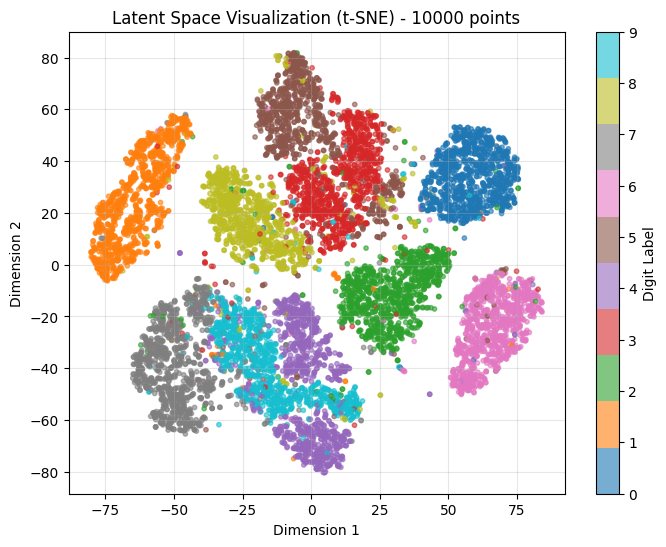

In [7]:
num_samples = 10000
collected_latents = []
collected_labels = []

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)

        _, latent = model(images)
        
        latent = latent.view(latent.size(0), -1)
        
        collected_latents.append(latent.cpu())
        collected_labels.append(labels.cpu())
        
        if sum(len(x) for x in collected_latents) >= num_samples:
            break

latent_set = torch.cat(collected_latents)[:num_samples] 
label_set = torch.cat(collected_labels)[:num_samples]

print(f"Computing t-SNE for {num_samples} samples...")

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
latent_2d = tsne.fit_transform(latent_set.numpy())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                      c=label_set.numpy(), 
                      cmap='tab10', 
                      s=10,       
                      alpha=0.6)  

plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title(f'Latent Space Visualization (t-SNE) - {num_samples} points')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

# **Comparing Original Images, Latent Representations, and Reconstructions**

This block visualizes how the autoencoder processes each digit class by selecting one example per MNIST digit (0–9) and displaying the full encoding–decoding pipeline.

The visualization is organized into three rows:
- **Original**: The input MNIST images for each digit
- **Latent**: A 2D summary of the encoder output, created by averaging across feature channels to reveal spatial activation patterns
- **Reconstructed**: The images produced by the decoder from the latent representations

By comparing these rows, this plot illustrates how well the autoencoder preserves digit structure through compression and reconstruction, as well as how different digits are represented in the latent space.

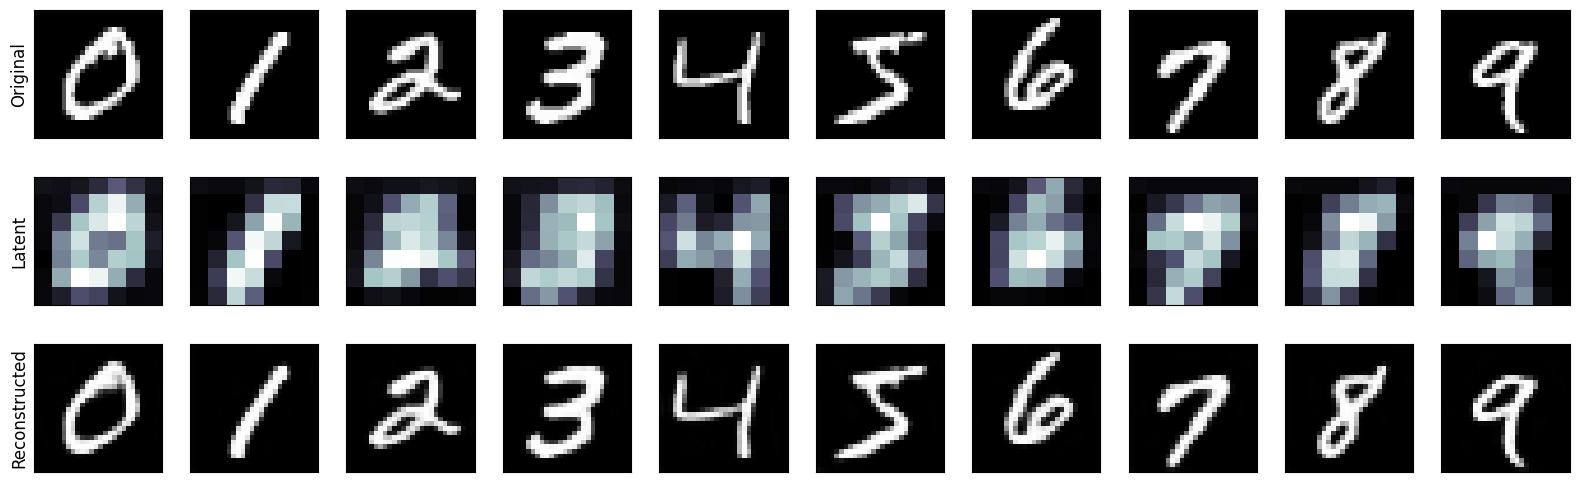

In [8]:
examples = {}
desired_labels = set(range(10))

for image, label in mnist_data:
    label_val = label
    if label_val in desired_labels and label_val not in examples:
        examples[label_val] = image.unsqueeze(0).to(device)
    if len(examples) == 10:
        break

fig, axes = plt.subplots(3, 10, figsize=(20, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

model.eval()
with torch.no_grad():
    for i in range(10):
        img_tensor = examples[i]
        encoded = model.encoder(img_tensor)
        latent_map = torch.mean(encoded, dim=1).squeeze().cpu()
        reconstructed = model.decoder(encoded).squeeze().cpu()
        original = img_tensor.squeeze().cpu()
        
        axes[0, i].imshow(original, cmap='gray')
        axes[0, i].set_xticks([]); axes[0, i].set_yticks([])
        if i == 0: axes[0, i].set_ylabel("Original", fontsize=12)
        
        axes[1, i].imshow(latent_map, cmap='bone')
        axes[1, i].set_xticks([]); axes[1, i].set_yticks([])
        if i == 0: axes[1, i].set_ylabel("Latent", fontsize=12)
        
        axes[2, i].imshow(reconstructed, cmap='gray')
        axes[2, i].set_xticks([]); axes[2, i].set_yticks([])
        if i == 0: axes[2, i].set_ylabel("Reconstructed", fontsize=12)

plt.show()